[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gsg213/Computer_Vision_DL/blob/master/intro_to_img_proc/HOG_MLP.ipynb)

# Training a MLP with HOG features

In [1]:
!wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip -O /content/cats_and_dogs_filtered.zip


--2021-03-29 00:36:41--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.128, 142.250.101.128, 2607:f8b0:4023:c06::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/content/cats_and_dogs_filtered.zip’

/content/cats_and_d 100%[===================>]  65.43M  90.9MB/s    in 0.7s    

2021-03-29 00:36:42 (90.9 MB/s) - ‘/content/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [2]:
!pip install rich

     |████████████████████████████████| 204kB 7.0MB/s 
     |████████████████████████████████| 51kB 5.1MB/s 


In [3]:
from rich import print

In [4]:
# to unzip

import os
import zipfile
comprimido = zipfile.ZipFile('cats_and_dogs_filtered.zip','r')
comprimido.extractall()
comprimido.close()

In [5]:
dir_base = 'cats_and_dogs_filtered'

dir_train_cat = os.path.join(dir_base,'train/cats')
dir_train_dog = os.path.join(dir_base,'train/dogs')

dir_val_cat = os.path.join(dir_base,'validation/cats')
dir_val_dog = os.path.join(dir_base,'validation/dogs')

#print first 10 names of data set
print(":cat:")
print(os.listdir(dir_train_cat)[:10])
print(":dog:")
print(os.listdir(dir_train_dog)[:10])

print('Cat train:',len(os.listdir(dir_train_cat)))
print('Cat val:',len(os.listdir(dir_val_cat)))

In [6]:
from skimage.feature import hog
from skimage.io import imread
from skimage.transform  import resize
from skimage.color import rgb2gray

import numpy as np

from matplotlib import pyplot as plt

In [7]:
#preprocess function to obation hog descriptors
def preprocess(file):
  img = imread(file)
  img_gray = rgb2gray(img)
  img_res = resize(img_gray,(128,64))
  fd1, hog_1 = hog(img_res, orientations = 9, pixels_per_cell = (16,16), cells_per_block = (4,4), visualize = True )

  return fd1

In [8]:
dir = dir_train_cat + '/cat.153.jpg'

fd = preprocess(dir)

print(fd.size)

In [9]:
def processAll(folder, label):
  hog_features = []
  labels = []

  for file in os.listdir(folder):
    nfile = folder + '/' + file

    his = preprocess(nfile)

    hog_features.append(his)
    labels.append(label)
  
  return hog_features, labels

In [10]:
folder_tra_cat = dir_train_cat
label_cat = 1

hog_tra_cat, label_tra_cat = processAll(folder_tra_cat,label_cat)

folder_tra_dog = dir_train_dog
label_dog = 0

hog_tra_dog, label_tra_dog = processAll(folder_tra_dog,label_dog)


In [11]:
hog_all = hog_tra_cat + hog_tra_dog

labels_all = label_tra_cat + label_tra_dog


hog_all = np.array(hog_all)
labels_all = np.array(labels_all)

print('hog: ', hog_all.shape)
print('labels: ',labels_all.shape)

In [12]:
labels_all = labels_all.reshape(len(labels_all),1)

dataset = np.hstack((hog_all,labels_all))
print(dataset.shape)

np.random.shuffle(dataset)

In [13]:
per = 80
dataset_per = int(len(hog_all)*per/100)

# :-1 all but last one
xtrain = dataset[:dataset_per,:-1]
xtest = dataset[dataset_per:,:-1]

ytrain = dataset[:dataset_per,-1:].ravel()
ytest = dataset[dataset_per:,-1:].ravel()

print('xtrain: ',xtrain.shape)
print('xtest: ',xtest.shape)

In [14]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(hog_all, labels_all,test_size= 0.2)

Creating the MLP to classify between cats and dogs using HOG features

In [15]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import plot_confusion_matrix

mlp = MLPClassifier(hidden_layer_sizes=(256,128,64,32),activation='relu',solver='adam',random_state=1).fit(xtrain,ytrain)


y_pred = mlp.predict(xtest)

print('score: ',mlp.score(xtest,ytest))


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


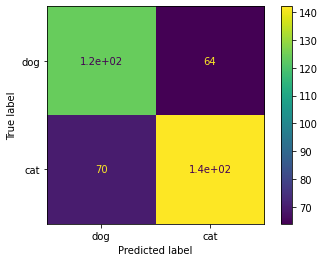

In [16]:
mc = plot_confusion_matrix(mlp,xtest,ytest,display_labels=['dog','cat'] )
plt.show()

# Exporting and importing model using pickle

In [17]:
import pickle

#export
pickle.dump(mlp,open('cats_dogs_MLP.sav','wb'))

#import
file_mlp = open('cats_dogs_MLP.sav','rb')
mlp_2 = pickle.load(file_mlp)

# Validating MLP model

In [18]:
#search images to validate
print(os.listdir(dir_val_dog)[:10])

Inference with trained model. Labels are:
*   Dog: 0     
*   Cat: 1

In [28]:
dir = dir_val_dog + '/dog.2164.jpg'
fd = preprocess(dir)
fd = np.reshape(fd,(1,fd.shape[0]))

mlp_2.predict(fd)[0]


0